## Fit $\langle N_b\rangle$ to $\tanh^4(\beta)$ at high $T$

## Imports

In [1]:
import time
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
from iterated_blocking import *
from utils import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit

%autoreload 2
%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))    # critical temperature

markers = ['s', 'H', 'd', 'v', 'p', 'P']
colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#ff7e79', '#959595']
markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',
                    '#ee2324','#1c2022']

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def tanh_fit_func(T, a, b):
    return a * (np.tanh(1/((T-Tc + b))**4))

In [5]:
def sech(x):
    return 1. / np.cosh(x)

def Nb_series_expansion(T):
    #return (4 * (L ** 2) * (np.tanh(1/T))**4) / (L**2)A
    #V = L ** 2
    beta = 1./ T
    sech
    prefactor = np.cosh(beta) * np.sinh(beta) 
    term1 = 4 * sech(beta) ** 2 * np.tanh(beta) ** 3
    term2 = 12 * sech(beta) ** 2 * np.tanh(beta) ** 5
    return prefactor * (term1 + term2)

## Load $\langle N_b\rangle$ data

In [12]:
Nb32_exact_data_file = '../data/Nb32Kexact.txt'
Nb32_exact_data = pd.read_csv(Nb32_exact_data_file, header=None, engine='c',
                              delim_whitespace=True).values
Nb32_exact_temps = Nb32_exact_data[:,0]
Nb32_exact = Nb32_exact_data[:, 1]

In [13]:
config_dir64 = '../data/configs/64_lattice/separated_data/'
iter_block_prefix = '../data/iterated_blocking/64_lattice/'
config_dir64_b32 = iter_block_prefix + 'blocked64_b32/configs/'
config_dir32_b16 = iter_block_prefix + 'blocked32_b16/configs/'
config_dir16_b8 = iter_block_prefix + 'blocked16_b8/configs/'
config_dir8_b4 = iter_block_prefix + 'blocked8_b4/configs/'
config_dir4_b2 = iter_block_prefix + 'blocked4_b2/configs/'

results_prefix = '../data/bond_stats/iterated_blocking/64_lattice/'
save_dir64_b32 = results_prefix + 'blocked_64_b32/results/'
save_dir32_b16 = results_prefix + 'blocked_32_b16/results/'
save_dir16_b8 = results_prefix + 'blocked_16_b8/results/'
save_dir8_b4 = results_prefix + 'blocked_8_b4/results/'
save_dir4_b2 = results_prefix + 'blocked_4_b2/results/'

config_dirs64 = [config_dir64_b32, config_dir32_b16, config_dir16_b8,
                 config_dir8_b4, config_dir4_b2]
results_dirs64 = [save_dir64_b32, save_dir32_b16, save_dir16_b8, 
                  save_dir8_b4, save_dir4_b2]

In [14]:
# unblocked, original <Nb> data on L = 64 lattice
count_bonds64 = CountBonds(L=64, load=True)

count_bonds64_b32 = CountBonds(L=32, load=True,
                               data_file=save_dir64_b32 + 'bond_stats_32.txt')
count_bonds32_b16 = CountBonds(L=16, load=True,
                               data_file=save_dir32_b16 + 'bond_stats_16.txt')
count_bonds16_b8 = CountBonds(L=8, load=True,
                              data_file=save_dir16_b8 + 'bond_stats_8.txt')
count_bonds8_b4 = CountBonds(L=4, load=True,
                             data_file=save_dir8_b4 + 'bond_stats_4.txt')
count_bonds4_b2 = CountBonds(L=2, load=True,
                             data_file=save_dir4_b2 + 'bond_stats_2.txt')

Reading from: ../data/bond_stats/64_lattice/bond_stats_64.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_64_b32/results/bond_stats_32.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_32_b16/results/bond_stats_16.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_16_b8/results/bond_stats_8.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_8_b4/results/bond_stats_4.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_4_b2/results/bond_stats_2.txt


In [21]:
bondstats32_data_file = (
    '../data/bond_stats/32_lattice_backup/bond_stats_32.txt'
)
count_bonds32 = CountBonds(32, load=True,
                           data_file=bondstats32_data_file)
Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds32.bond_stats.keys())
])

Reading from: ../data/bond_stats/32_lattice_backup/bond_stats_32.txt


### Format data for plotting

In [16]:
Nb64 = np.array([
    (i[0], i[1]) for i in list(count_bonds64.bond_stats.values())
])
delta_Nb64 = np.array([
    (i[2], i[3]) for i in list(count_bonds64.bond_stats.values())
])
Nb64_temps = np.array([
    float(i) for i in list(count_bonds64.bond_stats.keys())
])

Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds64_b32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds64_b32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds64_b32.bond_stats.keys())
])

Nb16 = np.array([
    (i[0], i[1]) for i in list(count_bonds32_b16.bond_stats.values())
])
delta_Nb16 = np.array([
    (i[2], i[3]) for i in list(count_bonds32_b16.bond_stats.values())
])
Nb16_temps = np.array([
    float(i) for i in list(count_bonds32_b16.bond_stats.keys())
])

Nb8 = np.array([
    (i[0], i[1]) for i in list(count_bonds16_b8.bond_stats.values())
])
delta_Nb8 = np.array([
    (i[2], i[3]) for i in list(count_bonds16_b8.bond_stats.values())
])
Nb8_temps = np.array([
    float(i) for i in list(count_bonds16_b8.bond_stats.keys())
])

Nb4 = np.array([
    (i[0], i[1]) for i in list(count_bonds8_b4.bond_stats.values())
])
delta_Nb4 = np.array([
    (i[2], i[3]) for i in list(count_bonds8_b4.bond_stats.values())
])
Nb4_temps = np.array([
    float(i) for i in list(count_bonds8_b4.bond_stats.keys())
])

Nb2 = np.array([
    (i[0], i[1]) for i in list(count_bonds4_b2.bond_stats.values())
])
delta_Nb2 = np.array([
    (i[2], i[3]) for i in list(count_bonds4_b2.bond_stats.values())
])
Nb2_temps = np.array([
    float(i) for i in list(count_bonds4_b2.bond_stats.keys())
])

## Try fitting

In [45]:
temps64_shifted = Nb64_temps - Tc
highT_idxs64 = np.where(temps64_shifted > 0)
temps64_highT = temps64_shifted[highT_idxs64]
Nb64_highT = Nb64[highT_idxs64, :][0]
delta_Nb64_highT = delta_Nb64[highT_idxs64, :][0]

In [63]:
temps32_shifted = Nb32_temps - Tc
highT_idxs32 = np.where(temps32_shifted > 0)
temps32_highT = temps32_shifted[highT_idxs32]
Nb32_highT = Nb32[highT_idxs32, :][0]
delta_Nb32_highT = delta_Nb32[highT_idxs32, :][0]

In [76]:
temps16_shifted = Nb16_temps - Tc
highT_idxs16 = np.where(temps16_shifted > 0.1)
temps16_highT = temps16_shifted[highT_idxs16]
Nb16_highT = Nb16[highT_idxs16, :][0]
delta_Nb16_highT = delta_Nb16[highT_idxs16, :][0]

In [94]:
temps8_shifted = Nb8_temps - Tc
highT_idxs8 = np.where(temps8_shifted > 0.4)
temps8_highT = temps8_shifted[highT_idxs8]
Nb8_highT = Nb8[highT_idxs8, :][0]
delta_Nb8_highT = delta_Nb8[highT_idxs8, :][0]

In [78]:
temps4_shifted = Nb4_temps - Tc
highT_idxs4 = np.where(temps4_shifted > 0.4)
temps4_highT = temps4_shifted[highT_idxs4]
Nb4_highT = Nb4[highT_idxs4, :][0]
delta_Nb4_highT = delta_Nb4[highT_idxs4, :][0]

In [89]:
popt64, pcov64 = curve_fit(tanh_fit_func, temps64_highT, Nb64_highT[:,0])

In [95]:
popt32, pcov32 = curve_fit(tanh_fit_func, temps32_highT, Nb32_highT[:,0])
popt16, pcov16 = curve_fit(tanh_fit_func, temps16_highT, Nb16_highT[:,0])
popt8, pcov8 = curve_fit(tanh_fit_func, temps8_highT, Nb8_highT[:,0])
popt4, pcov4 = curve_fit(tanh_fit_func, temps4_highT, Nb4_highT[:,0])

<IPython.core.display.Javascript object>


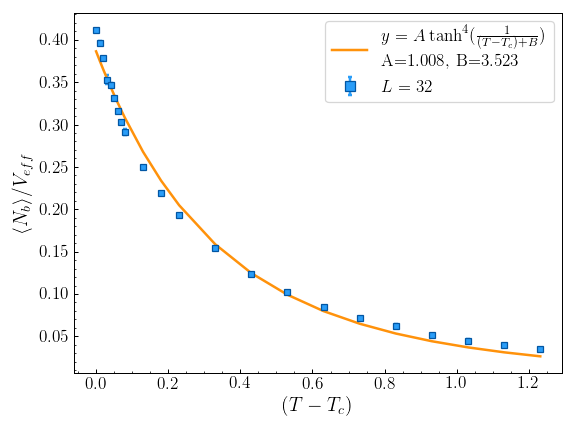

<Container object of 3 artists>

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

Text(0.5,0,'$(T - T_c)$')

In [97]:
#scale_arr = [(32*32), (32*32), (32*32), (32*32), (4*4)]
fit_params = (popt32[0] / (32*32), popt32[1])
fit_string = (r"$y = A\tanh^4(\frac{1}{(T - T_c) + B})$"
              + '\n A=%5.3f, B=%5.3f' % tuple(fit_params))
fig, ax = plt.subplots()
ax.errorbar(temps32_highT, Nb32_highT[:,0] / (32*32), 
            yerr=Nb32_highT[:,1] / (32*32),
            label=r"$L = 32$", marker=markers[0], markersize=5, 
            fillstyle='full', color=colors[0], 
            markeredgecolor=markeredgecolors[0], 
            ls='', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=1.))
ax.plot(temps32_highT, tanh_fit_func(temps32_highT, *fit_params), 'r-',
        color=colors[1], lw=2., label= fit_string)
ax.set_ylabel(r"$\langle N_b\rangle / V_{eff}$", fontsize=16)
ax.set_xlabel(r"$(T - T_c)$", fontsize=16)
ax.legend(loc='best', markerscale=1.5, fontsize=14)
fig.tight_layout()
plot_dir = '../plots/tanh4_fits/L_32/'
plot_num = get_plot_num(plot_dir)
plot_file = plot_dir + f'Nb_avg_vs_T_fit32_{plot_num}.png'
fig.savefig(plot_file,  dpi=400, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


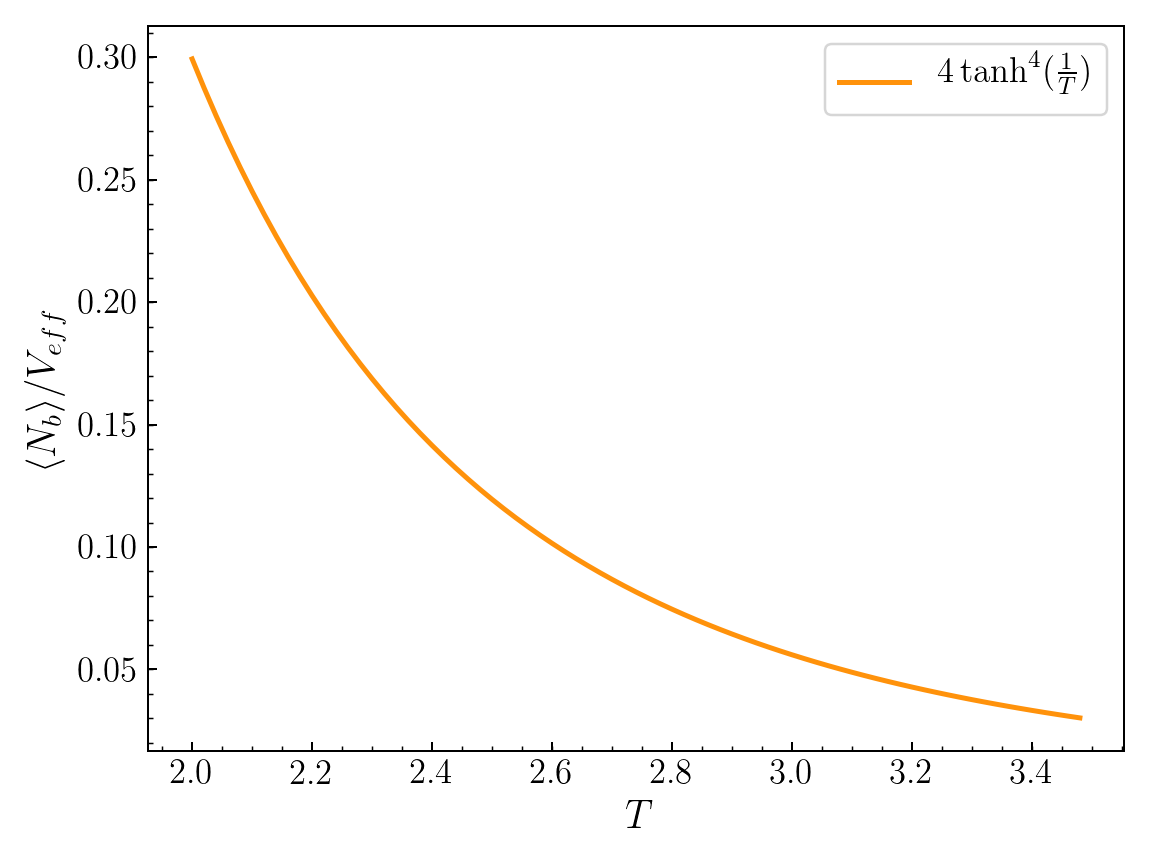

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

Text(0.5,0,'$T$')

In [9]:
fig, ax = plt.subplots()
ax.plot(T_compare, Nb_compare,
        color=colors[1], lw=2., label=r"$4\tanh^4(\frac{1}{T})$")
ax.set_ylabel(r"$\langle N_b\rangle / V_{eff}$", fontsize=16)
ax.set_xlabel(r"$T$", fontsize=16)
ax.legend(loc='best', markerscale=1.5, fontsize=14)
fig.tight_layout()
#plot_dir = '../plots/tanh4_fits/L_32/'
#plot_num = get_plot_num(plot_dir)
#plot_file = plot_dir + f'Nb_avg_vs_T_fit32_{plot_num}.png'
#fig.savefig(plot_file,  dpi=400, bbox_inches='tight')
plt.show()

## Using Kauffman's exact solution

In [28]:
T_compare = np.arange(1., 5, 0.02)
Nb_compare = Nb_series_expansion(T_compare)

<IPython.core.display.Javascript object>


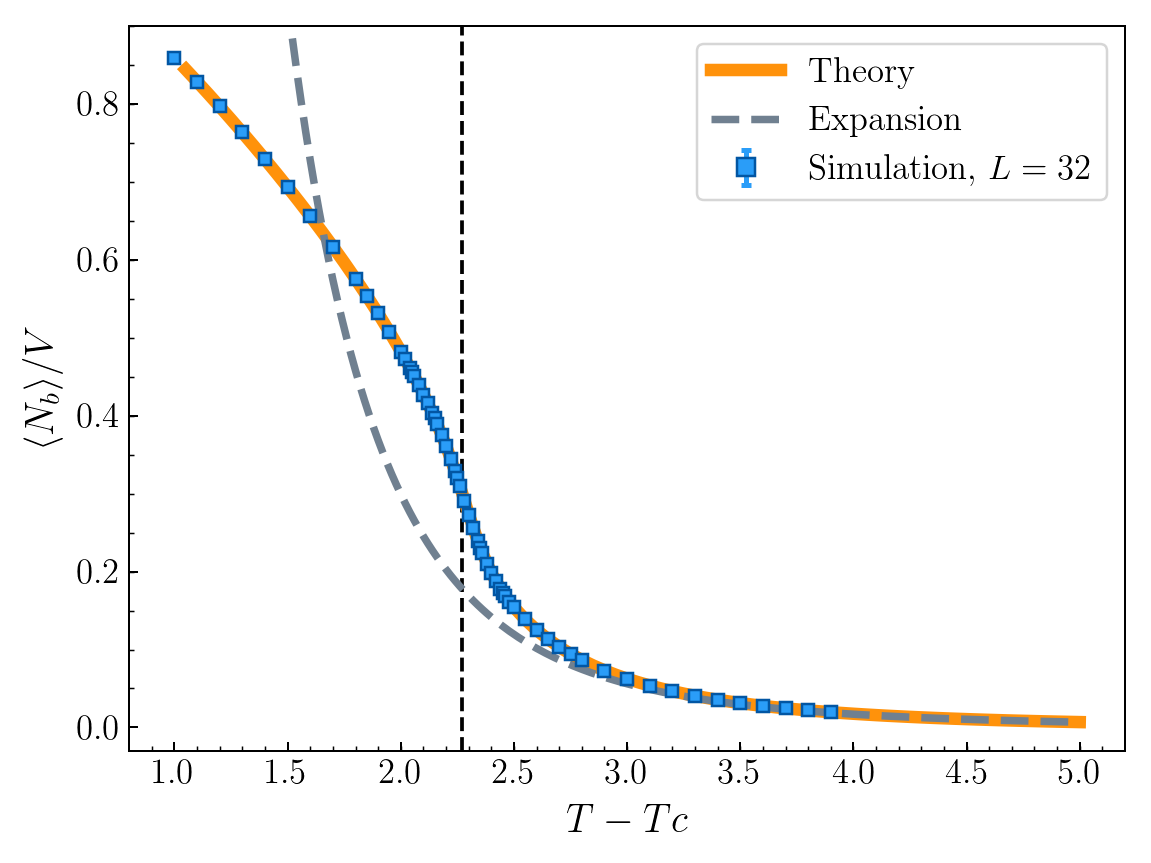

<Container object of 3 artists>

Text(0,0.5,'$\\langle N_b\\rangle / V$')

Text(0.5,0,'$T - Tc$')

(-0.03, 0.9)

In [39]:
fig, ax = plt.subplots()
ax.axvline(x=Tc, linestyle='--', color='k')
#ax.errorbar(Nb64_temps, Nb64[:,0] / (64*64), 
#            yerr=Nb64[:,1] / (64*64),
#            label=r"Simulation, $L=64$", marker=markers[0], markersize=5, 
#            fillstyle='full', color=colors[0], 
#            markeredgecolor=markeredgecolors[0], 
#            ls='', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=1.))
ax.errorbar(Nb32_temps, Nb32[:,0] / (32*32), 
            yerr=Nb32[:,1] / (32*32),
            label=r"Simulation, $L=32$", marker=markers[0], markersize=5, 
            fillstyle='full', color=colors[0], 
            markeredgecolor=markeredgecolors[0], 
            ls='', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=1.))
ax.plot(Nb32_exact_temps, Nb32_exact/(32*32), 
        color=colors[1], lw=5., ls='-',
        label="Theory")
ax.plot(T_compare, Nb_compare,
        color='slategrey', lw=3., ls='--', label=r"Expansion")
ax.set_ylabel(r"$\langle N_b\rangle / V$", fontsize=16)
ax.set_xlabel(r"$T - Tc$", fontsize=16)
ax.set_ylim(-0.03, 0.9)
ax.legend(loc='best', markerscale=1.5, fontsize=14)
fig.tight_layout()
plot_dir = '../plots/Nb_compare/L_32/'
plot_num = get_plot_num(plot_dir)
plot_file = plot_dir + f'Nb_avg_vs_T_with_exact_{plot_num}.png'
fig.savefig(plot_file,  dpi=400, bbox_inches='tight')
plt.show()